# Cloud labelling

**Background**

**What does this notebook do?** This notebook helps generate a labelled dataset of cloud and non-cloud pixels from Sentinel 2. We want to label a handful of time slices from a 5 x 5 km cube. We will need pixels representing a wide range of land features, including buildings, water, and terrain; different cubes will be required for different climate zones throughout Australia.

**Date**: Aug 2020.

**Author**: Matthew Alger

## Setup

In [3]:
%%bash
pip install rioxarray

Processing /home/jovyan/.cache/pip/wheels/d0/d8/f9/caa0e5b4936f60d2f2156c9092c3c7c4a3abd9c8163c22d2ec/rioxarray-0.0.31-py3-none-any.whl


You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [326]:
%matplotlib widget

import functools
import os
import sys
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rioxarray
from shapely.geometry import shape
import skimage.color as colour
import skimage.io
from tqdm.notebook import tqdm
import xarray

sys.path.append('../Scripts')
from dea_dask import create_local_dask_cluster
from dea_datahandling import load_ard, array_to_geotiff
from dea_plotting import rgb

In [352]:
dc = datacube.Datacube(app='cloud-labelling')

In [9]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:37969 Dashboard: /user/alger/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [361]:
centre_deg = (lat, lon) = (-35.2809, 149.1300)  # Civic
# centre_deg = (lat, lon) = (-35.4244, 149.1300)  # Tuggeranong
radius_m = 2500
m_to_deg = datacube.utils.geometry.crs_units_per_degree('EPSG:3577', lat=lat, lon=lon)
radius_deg = radius_m / m_to_deg

bands = ['nbart_red', 'nbart_green', 'nbart_blue', 'fmask']
rgb_bands = bands[:3]

query = {
    'x': (lon - radius_deg, lon + radius_deg),
    'y': (lat - radius_deg, lat + radius_deg),
    'time': ('2015-01', '2020-08'),
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000},
    'group_by': 'solar_day',
     'resampling': {'fmask': 'nearest', '*': 'average'},
    'measurements': bands,
}

In [365]:
ds = dc.load(product='s2a_ard_granule',
             progress_cbk=with_ui_cbk(),
             **query)

In [364]:
ds_tsmask = dc.load('s2_tsmask', progress_cbk=with_ui_cbk(), **{k:v for k, v in query.items() if k not in {'measurements'}})

In [ ]:
time_samples = [0, 10, 20, 30, 40, 50]
rgb(ds.isel(time=time_samples), bands=rgb_bands, col='time', col_wrap=3, size=1)

## Sorting a cube by cloudiness

Using fmask, sort a cube by the percentage of each time slice covered by cloud.

In [13]:
fmask = ds.fmask.load()

In [14]:
fmask.attrs['flags_definition']['fmask']['values']

{'0': 'nodata',
 '1': 'valid',
 '2': 'cloud',
 '3': 'shadow',
 '4': 'snow',
 '5': 'water'}

In [15]:
pc_cloudy = make_mask(fmask, fmask='cloud').values.mean(axis=(1, 2))

In [16]:
ds['cloudiness'] = xarray.DataArray(data=pc_cloudy, coords={'time': ds.time}, dims='time')

In [17]:
ds_sorted = ds.sortby('cloudiness')

From a histogram of cloudiness, we can see that there is a peak at 0.2. This arises from fmask incorrectly identifying Civic as cloud.

In [20]:
plt.figure()
plt.hist(pc_cloudy, bins=30)
plt.xlabel('Cloud fraction')
plt.ylabel('Number of time stamps')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Number of time stamps')

Compare the rate at which each pixel is masked with an image from the 0.2 peak.

In [21]:
plt.figure(figsize=(15, 4))
idx = abs(ds_sorted.cloudiness - 0.2).argmin()
ax = plt.subplot(1, 3, 1)
rgb(ds_sorted.isel(time=idx), ax=ax, bands=rgb_bands)
ax.set_title('20% cloudy RGB')
ax = plt.subplot(1, 3, 2)
ds_sorted.isel(time=idx).fmask.plot()
ax.set_title('20% cloudy fmask')
ax = plt.subplot(1, 3, 3)
make_mask(fmask, fmask='cloud').sum(axis=0).plot(ax=ax)
ax.set_title('Number of times masked')
plt.tight_layout()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Full-image labels

When the full image is cloud-free or cloudy, we can get "free" validation data because the whole image gets the same label. This section includes a widget for rapidly labelling the cube.

In [22]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
current_index = 0
labels = []

progress_bar = tqdm(total=ds_sorted.fmask.shape[0])

def plot_slice(index):
    ax.cla()
    rgb(ds_sorted.isel(time=index), ax=ax)
plot_slice(current_index)

def handle_click(button):
    global current_index
    desc = button.description
    labels.append(desc)
    current_index += 1
    if current_index < len(ds_sorted.fmask):
        progress_bar.update(1)
        plot_slice(current_index)

def handle_undo(button):
    global current_index
    current_index -= 1
    labels.pop()
    if current_index < len(ds_sorted.fmask):
        progress_bar.update(-1)
        plot_slice(current_index)
    
button_all_clear = widgets.Button(
    description='Clear',
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='sun')
button_all_cloud = widgets.Button(
    description='Opaque',
    button_style='',
    icon='cloud')
button_all_trans = widgets.Button(
    description='Transparent',
    button_style='',
    icon='wind')
button_mixed = widgets.Button(
    description='Mixed',
    button_style='',
    icon='cloud-sun')
button_undo = widgets.Button(
    description='Undo',
    button_style='info',
    icon='undo')
buttons = [button_mixed, button_all_clear, button_all_cloud, button_all_trans]
for button in buttons:
    button.on_click(handle_click)
button_undo.on_click(handle_undo)

widgets.VBox([widgets.HBox(buttons), button_undo])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
fn = 'full_image_labels_canberra_20200807.txt'
if not os.path.exists(fn):
    np.savetxt(fn, np.stack([ds_sorted.time.values.astype('<U29'), labels]).T, fmt='%s')

In [26]:
saved_labels = np.loadtxt('full_image_labels_canberra_20200807.txt', dtype='<U29')
assert (saved_labels[:, 0] == ds_sorted.time.values.astype('<U29')).all()
labels = saved_labels[:, 1]

In [27]:
plt.figure()
plt.hist(labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([55.,  0.,  0., 66.,  0.,  0., 29.,  0.,  0.,  2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

We can also now look at agreement with fmask.

In [192]:
fmask.flags_definition['fmask']['values']

{'0': 'nodata',
 '1': 'valid',
 '2': 'cloud',
 '3': 'shadow',
 '4': 'snow',
 '5': 'water'}

In [200]:
fm_cm = np.array([[0, 0], [0, 0]])
for label, fm in zip(labels, fmask):
    # How many pixels are masked that should be masked?
    if label == 'Clear':
        # Clear, so nothing should be masked.
        # Clear pixels are true negatives:
        fm_cm[0, 0] += (fm == 1).sum()
        # Cloud pixels are false positives:
        fm_cm[1, 0] += (fm == 2).sum()
    elif label in {'Opaque', 'Transparent'}:
        # Cloud, so everything should be masked.
        # Clear pixels are false negatives:
        fm_cm[0, 1] += (fm == 1).sum()
        # Cloud pixels are true positives:
        fm_cm[1, 1] += (fm == 2).sum()
fm_cm / fm_cm.sum(axis=0, keepdims=True)

array([[0.3585414 , 0.33658459],
       [0.6414586 , 0.66341541]])

## Partial-image labels

Let's sample from the cloudiness axis (for mixed images). Say, 9 samples for each cube, evenly spaced between 0 and 1.

In [418]:
mixed = labels == 'Mixed'

In [419]:
_mixed_idxs = np.arange(len(mixed))[mixed]

In [420]:
idxs = []
for pc in np.linspace(0, 1, 9):
    idxs.append(_mixed_idxs[abs(ds_sorted.cloudiness[mixed] - pc).argmin()])

In [422]:
rgb(ds_sorted.isel(time=idxs), col='time', col_wrap=3, percentile_stretch=[0.02, 0.80], size=2)
# for i, ax in enumerate(plt.gcf().axes):
#     ax.set_title('{:.02%}'.format(ds_sorted.isel(time=idxs[i]).cloudiness.values))

/env/lib/python3.6/site-packages/xarray/plot/facetgrid.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Now let's label these. We'll use an ipyleaflet widget based on `Imagery_on_web_map.ipynb` and `interactive_polygons.ipynb`. At the moment there seems no good way to label multiple different polygons, so we will only fill in opaque cloud on this map.

In [201]:
def get_interactive_map(time_idxs):
    # Set up the map.
    bbox = ds.geobox.extent.to_crs('EPSG:4326').boundingbox
    zoom = odc.ui.zoom_from_bbox(bbox)
    center = (bbox.bottom + bbox.top) * 0.5, (bbox.right + bbox.left) * 0.5
    m = ipyleaflet.Map(
        center=center,
        zoom=zoom,
        scroll_wheel_zoom=True,  # Allow zoom with the mouse scroll wheel
        layout=widgets.Layout(
            width='600px',   # Set Width of the map to 600 pixels, examples: "100%", "5em", "300px"
            height='600px',  # Set height of the map
        ))
    
    def add_image_layer(time_idx):
        # Add the image.
        # If the time axis has 0 shape, or >1 element, mk_image_overlay fails. https://github.com/opendatacube/odc-tools/issues/75
        # rioxarray doesn't like having more than x and y coordinate axes.
        img_layer = odc.ui.mk_image_overlay(
            ds_sorted.isel(time=time_idx).drop('time').drop('cloudiness').rio.reproject(
                dst_crs='EPSG:3857', shape=ds.fmask.shape[1:], resampling=rasterio.warp.Resampling.bilinear),
            bands=rgb_bands,
            clamp=3000,
            fmt='jpeg')
        m.add_layer(img_layer)
        return img_layer
    
    idx = 0
    img_layer = add_image_layer(time_idxs[idx])
    
    # Add the drawing controls.
    fill_colours = {'Opaque': '#BEBEFF', 'Clear': '#BEFFBE', 'Transparent': '#FFBEBE'}
    feature_collection = {
        'type': 'FeatureCollection',
        'features': [],
    }
    
    
    for type_ in ['Opaque']:  # This is how I'd like to do multiple types in the one image, but I can't figure out how to label the icons.
        draw_control = ipyleaflet.DrawControl()
        draw_control.polygon = {
            "shapeOptions": {
                "fillColor": fill_colours[type_],
                "color": fill_colours[type_],
            },
            "allowIntersection": False,
        }
        # Disable polyline and circlemarker controls so that only polygon remains.
        draw_control.polyline = {}
        draw_control.circlemarker = {}
        def handle_draw(self, action, geo_json):
            geo_json['properties']['type'] = type_
            geo_json['properties']['index'] = time_idxs[idx]
            feature_collection['features'].append(geo_json)
        draw_control.on_draw(handle_draw)
        draw_control.edit = False
        draw_control.remove = False
        m.add_control(draw_control)
        
    draw_control.edit = True
    draw_control.remove = True
    
    # Add next button.
    button_next = widgets.Button(
        description='Next',
        button_style='info',
        icon='next')
    def on_click(self):
        nonlocal idx
        nonlocal img_layer
        if idx + 1 < len(time_idxs):
            idx += 1
            m.remove_layer(img_layer)
            img_layer = add_image_layer(time_idxs[idx])
            draw_control.clear_polygons()
    button_next.on_click(on_click)
    
    # Need to return feature_collection or it will be stuck inside the function.
    return widgets.VBox([button_next, m]), feature_collection

In [202]:
map_, fc = get_interactive_map(idxs)
map_

This gives us a GeoJSON FeatureCollection.

In [453]:
fc_ = gpd.GeoDataFrame({'geometry': [shape(s['geometry']) for s in fc['features']], 'time_index': [s['properties']['index'] for s in fc['features']]})

In [454]:
plt.figure()
ax = plt.subplot(1, 1, 1)
rgb(ds_sorted.isel(time=idxs[0]), ax=ax)
fc_[fc_.time_index == idxs[0]].set_crs('EPSG:4326').to_crs('EPSG:3577').boundary.plot(ax=ax)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

We can then rasterise the polygons.

In [471]:
rasters = []
for i in range(len(idxs)):
    sh = fc_[fc_.time_index == idxs[i]].set_crs('EPSG:4326').to_crs('EPSG:3577')
    raster_polygons = rasterio.features.rasterize(shapes=sh.geometry,
                                                  out_shape=(ds_sorted.y.shape[0], ds_sorted.x.shape[0]),
                                                  all_touched=True,
                                                  fill=0,
                                                  default_value=1,
                                                  transform=ds_sorted.fmask.geobox.transform)
    rasters.append(raster_polygons)
rasters = np.array(rasters)
rasters = xarray.DataArray(data=rasters, coords=ds_sorted.fmask.isel(time=idxs).coords)

In [473]:
rasters.plot(col='time', col_wrap=3)

/env/lib/python3.6/site-packages/xarray/plot/facetgrid.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Then we make some xarrays for fully clear and fully opaque or transparent images.

In [474]:
clear_times = saved_labels[labels == 'Clear', 0]
clear = [xarray.zeros_like(fmask.sel(time=t)) + 1 for t in clear_times]
cloud_times = saved_labels[(labels == 'Transparent') | (labels == 'Opaque'), 0]
cloud = [xarray.zeros_like(fmask.sel(time=t)) + 2 for t in cloud_times]
full_labels = xarray.concat(clear + cloud, dim='time')

In [475]:
all_labels = xarray.concat([rasters + 1, full_labels], dim='time')

In [1]:
datacube.utils.cog.write_cog(all_labels.sortby('time'), 'labels.tif')

NameError: name 'datacube' is not defined

In [477]:
plt.figure()
plt.plot(all_labels.sum(dim=('x', 'y')))

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Let's look at ts_mask and fmask on this same dataset.

In [478]:
test_times = all_labels.time

In [482]:
plt.figure()
ax = plt.subplot(1, 1, 1)
rgb(ds_sorted.sel(time=test_times[0]), ax=ax)
all_labels.sel(time=test_times[0]).plot.contour(ax=ax)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

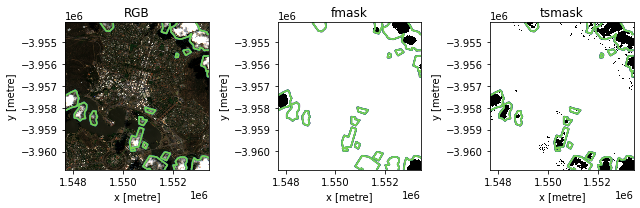

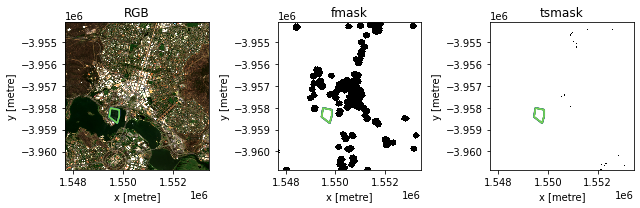

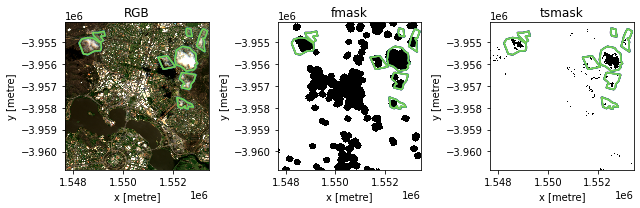

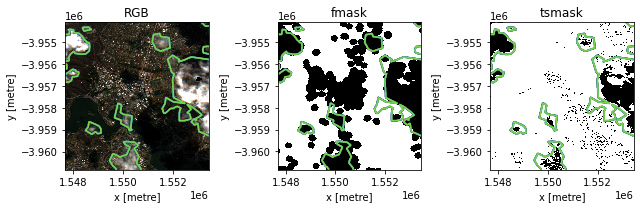

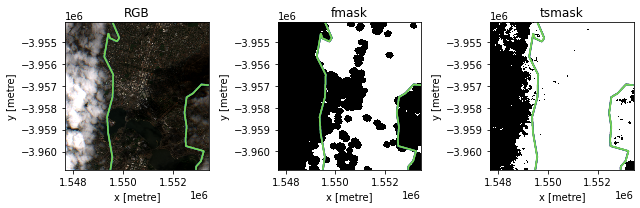

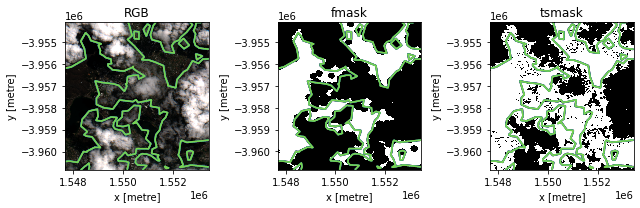

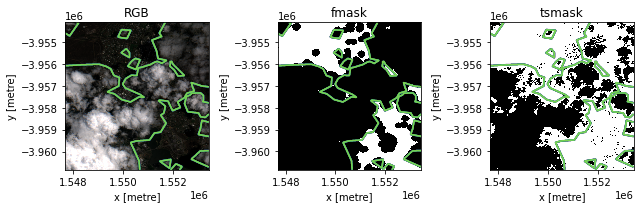

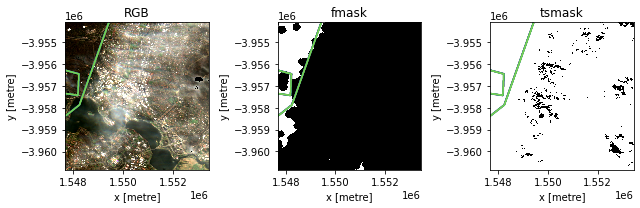

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


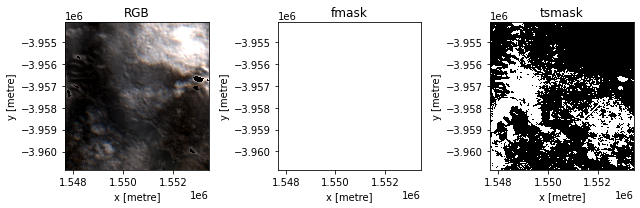

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


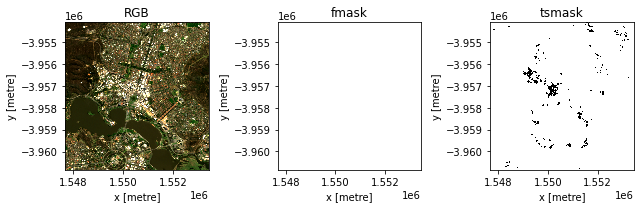

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


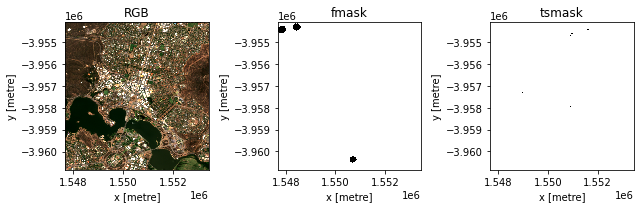

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


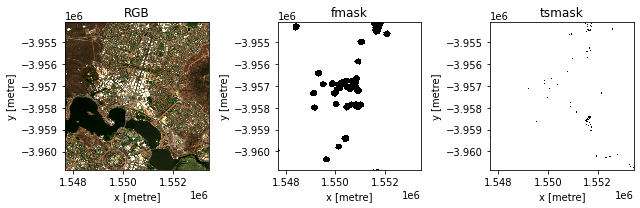

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


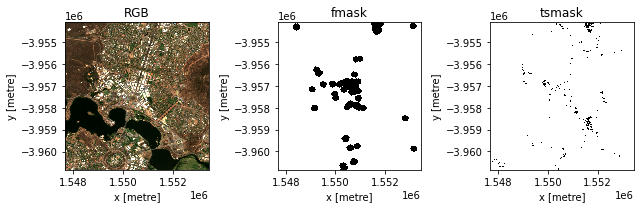

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


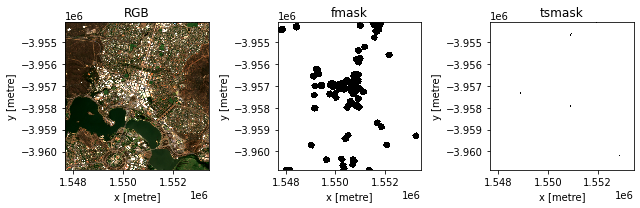

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


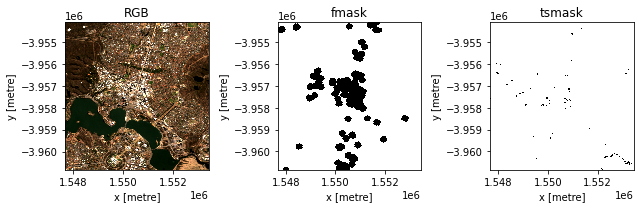

/env/lib/python3.6/site-packages/xarray/plot/plot.py:906: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


KeyError: 1572566561024000000

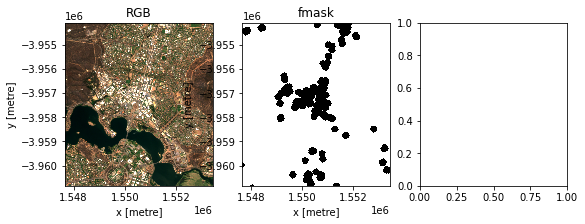

distributed.nanny - WARNING - Restarting worker
distributed.nanny - ERROR - Nanny failed to start process
Traceback (most recent call last):
  File "/env/lib/python3.6/site-packages/distributed/nanny.py", line 575, in start
    await self.process.start()
  File "/env/lib/python3.6/site-packages/distributed/process.py", line 34, in _call_and_set_future
    res = func(*args, **kwargs)
  File "/env/lib/python3.6/site-packages/distributed/process.py", line 202, in _start
    process.start()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 284, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_spawn_posix.py", line 32, in __init__
    super().__init__(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_spawn_posix

In [504]:
%matplotlib inline
for t in test_times:
    plt.figure(figsize=(9, 3))
    ax = plt.subplot(1, 3, 1)
    rgb(ds.sel(time=t), ax=ax)
    all_labels.sel(time=t).plot.contour(ax=ax)
    ax.set_title('RGB')
    ax = plt.subplot(1, 3, 2)
    (fmask.sel(time=t) == 2).plot(ax=ax, cmap='Greys', add_colorbar=False)
    all_labels.sel(time=t).plot.contour(ax=ax)
    ax.set_title('fmask')
    ax = plt.subplot(1, 3, 3)
    (ds_tsmask.classification == 2).sel(time=t).plot(ax=ax, cmap='Greys', add_colorbar=False)
    all_labels.sel(time=t).plot.contour(ax=ax)
    ax.set_title('tsmask')
    plt.tight_layout()
    plt.show()